## 2020707035 박시언 lab3
1. 데이터를 분석합니다.
2. 데이터를 9개의 구간으로 나눠서 "로그1p변환"의 값으로 평균, 분산, 표준편자 등등 통계 데이터를 활용하여 feature를 만들어냅니다.
3. 8번은 pass에 대해서는 데이터 증강을 진행하지 않습니다. 나머지 케이스는 데이터를 증강합니다.
4. ADASYN으로 2차 증강을 진행합니다.
5. 증강 안하고 fitering만 한 데이터와, augmentation을 진행한 데이터, augmentation & adasyn 까지 적용한 데이터 각각 성능 평가를 진행합니다.
6. 베이지안 최적화 모듈을 통해서 최적의 파라미터를 구하고 해당 모델을 다시 평가합니다.
7. 최종 벨런스스코어는 0.72가 나옵니다.

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.ndimage import median_filter, rotate, shift
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from torch.xpu import device

In [31]:
df = pd.read_pickle("/home/unsi/다운로드/LSWMD.pkl")  #우분투 -> /home/unsi/다운로드/LSWMD.pkl || 맥 -> /Users/unsi/Downloads/LSWMD.pkl

In [32]:
df.iloc[35]['failureType']

array([], shape=(0, 0), dtype=float64)

In [33]:
# 빈 리스트를 포함하는 행만 필터링하기
passed = df[df['failureType'].apply(lambda x: x.shape == (0, 0) or x[0][0] == 'none')]
passed['failureType'] = 8
eda_pass = passed
passed = passed.sample(n=100000, random_state=42)

/tmp/ipykernel_8466/2072027894.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  passed['failureType'] = 8


In [34]:
# Filtering rows based on a nested condition in the 'failureType' column
faild = df[df['failureType'].apply(lambda x: len(x) > 0 and len(x[0]) > 0 and x[0][0] != 'none')]
faild

,waferMap,dieSize,lotName,waferIndex,trianTestLabel,failureType
19,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,20.0,[[Training]],[[Loc]]
36,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2460.0,lot2,12.0,[[Training]],[[Edge-Loc]]
37,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2460.0,lot2,13.0,[[Training]],[[Edge-Loc]]
38,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2460.0,lot2,14.0,[[Training]],[[Edge-Loc]]
39,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2460.0,lot2,15.0,[[Training]],[[Edge-Loc]]
...,...,...,...,...,...,...
811450,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 2,...",600.0,lot47542,21.0,[[Test]],[[Edge-Loc]]
811451,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,...",600.0,lot47542,22.0,[[Test]],[[Edge-Loc]]
811452,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...",600.0,lot47542,23.0,[[Test]],[[Edge-Ring]]
811453,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1, 1,...",600.0,lot47542,24.0,[[Test]],[[Edge-Loc]]


In [35]:
faild.columns

Index(['waferMap', 'dieSize', 'lotName', 'waferIndex', 'trianTestLabel',
       'failureType'],
      dtype='object')

In [36]:
class2idx = {
    'Loc': 0,
    'Edge-Loc': 1,
    'Center': 2,
    'Edge-Ring': 3,
    'Scratch': 4,
    'Random': 5,
    'Near-full': 6,
    'Donut': 7,
    'pass': 8
}

#failureType 인코딩 
faild['failureType'] = faild['failureType'].apply(lambda x: class2idx.get(x[0][0], -1))

# 결과 확인
faild


/tmp/ipykernel_8466/1474913133.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  faild['failureType'] = faild['failureType'].apply(lambda x: class2idx.get(x[0][0], -1))


,waferMap,dieSize,lotName,waferIndex,trianTestLabel,failureType
19,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,20.0,[[Training]],0
36,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2460.0,lot2,12.0,[[Training]],1
37,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2460.0,lot2,13.0,[[Training]],1
38,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2460.0,lot2,14.0,[[Training]],1
39,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2460.0,lot2,15.0,[[Training]],1
...,...,...,...,...,...,...
811450,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 2,...",600.0,lot47542,21.0,[[Test]],1
811451,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,...",600.0,lot47542,22.0,[[Test]],1
811452,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...",600.0,lot47542,23.0,[[Test]],3
811453,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1, 1,...",600.0,lot47542,24.0,[[Test]],1


In [37]:
df = pd.concat([faild, passed])
df


,waferMap,dieSize,lotName,waferIndex,trianTestLabel,failureType
19,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,20.0,[[Training]],0
36,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2460.0,lot2,12.0,[[Training]],1
37,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2460.0,lot2,13.0,[[Training]],1
38,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2460.0,lot2,14.0,[[Training]],1
39,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2460.0,lot2,15.0,[[Training]],1
...,...,...,...,...,...,...
334843,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",5532.0,lot20174,4.0,[],8
609203,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1,...",710.0,lot38319,13.0,[],8
244074,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 2,...",648.0,lot15275,11.0,[],8
379250,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2393.0,lot22590,20.0,[],8


In [38]:
eda_df = pd.concat([faild, eda_pass])

# EDA
1. pass fail 분포를 확인합니다. 각각의 클래스 또한 확인합니다.
2. 웨이퍼 맵에 어느 부분에 불량 다이가 분포했는지 확인합니다. (웨이퍼맵을 9개로 등분하여 각각 0,1,2,3,4,5,6,7,8,9 의 구간으로 나눕니다.)

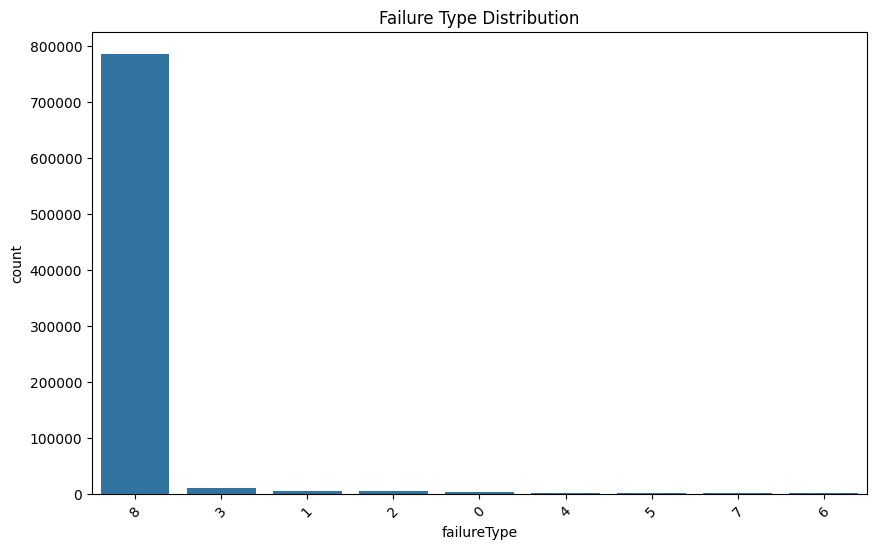

In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 데이터 로드 및 pass/fail 분포 확인
eda_df['pass_fail'] = eda_df['failureType'].apply(lambda x: 'pass' if x == 'None' else 'fail')


# 클래스별 분포 확인 (None은 제외하고 나머지 분포)
plt.figure(figsize=(10, 6))
sns.countplot(x='failureType', data=eda_df[eda_df['failureType'] != 'None'], order=eda_df['failureType'].value_counts().index)
plt.title('Failure Type Distribution')
plt.xticks(rotation=45)
plt.show()


Average occurrences of value 2 for each section: [ 8.59986427 12.33676421  8.48929535 12.65850151 10.73069528 13.18520254
  9.35990241 12.5659164   8.8014833 ]


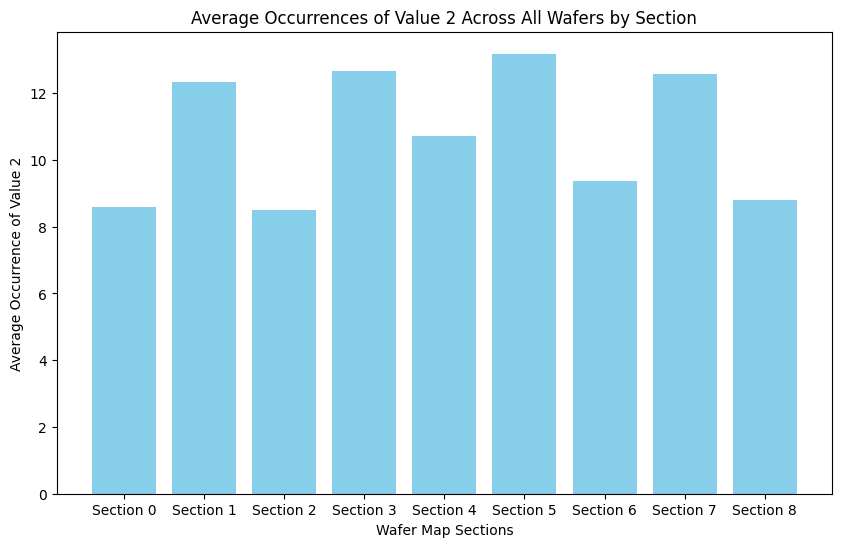

In [48]:
import numpy as np
import matplotlib.pyplot as plt

# 웨이퍼 맵을 9개의 구간으로 나누는 함수
def divide_wafer_map(wafer_map, grid_size=(3, 3)):
    rows, cols = wafer_map.shape
    row_step, col_step = rows // grid_size[0], cols // grid_size[1]
    
    divided_map = []
    for i in range(0, rows, row_step):
        for j in range(0, cols, col_step):
            section = wafer_map[i:i + row_step, j:j + col_step]
            divided_map.append(section)
    
    if len(divided_map) == 9:
        return divided_map
    else:
        return None

# 각 웨이퍼 맵의 구간에서 값 2가 나타난 빈도를 계산하는 함수
def calculate_occurrences_of_value(wafer_map, target_value=2):
    sections = divide_wafer_map(wafer_map)
    if sections is None:
        return None
    
    occurrence_counts = []
    for section in sections:
        count_value = np.sum(section == target_value)  # 해당 값(2)이 나타난 빈도 계산
        occurrence_counts.append(count_value)
    
    return occurrence_counts

# 모든 웨이퍼 맵에 대해 구간별로 2가 나타난 빈도의 평균을 계산
total_occurrences = np.zeros(9)  # 각 구간에서 2가 나타난 빈도 합계 저장
num_wafer_maps = 0  # 분석된 웨이퍼 맵 개수

for i, row in eda_df.iterrows():
    if isinstance(row['waferMap'], np.ndarray):
        occurrences = calculate_occurrences_of_value(row['waferMap'], target_value=2)
        if occurrences is not None:  # 유효한 구간 나누기가 된 경우만 처리
            total_occurrences += occurrences  # 각 구간에서 2가 나타난 빈도 합산
            num_wafer_maps += 1

# 전체 웨이퍼에 대한 각 구간에서 2가 나타난 평균 빈도 계산
if num_wafer_maps > 0:
    average_occurrences = total_occurrences / num_wafer_maps
    print(f'Average occurrences of value 2 for each section: {average_occurrences}')
else:
    print("No valid wafer maps were found.")

# 구간별 평균 2의 빈도 시각화
plt.figure(figsize=(10, 6))
plt.bar(range(9), average_occurrences, color='skyblue')
plt.title('Average Occurrences of Value 2 Across All Wafers by Section')
plt.xlabel('Wafer Map Sections')
plt.ylabel('Average Occurrence of Value 2')
plt.xticks(range(9), labels=[f'Section {i}' for i in range(9)])
plt.show()


In [10]:
from sklearn.model_selection import train_test_split
train_df,test_df,_,__ = train_test_split(df,np.random.randn(len(df)), test_size=0.2, random_state=42,stratify=df['failureType'])

In [11]:
train_df

,waferMap,dieSize,lotName,waferIndex,trianTestLabel,failureType
179989,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2,...",1109.0,lot11503,14.0,[],8
424647,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",3701.0,lot25468,3.0,[],8
641835,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2,...",533.0,lot40415,6.0,[[Test]],2
517234,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 2,...",515.0,lot32340,12.0,[],8
317057,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2570.0,lot19274,15.0,[],8
...,...,...,...,...,...,...
13483,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",924.0,lot2118,1.0,[],8
453013,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2,...",733.0,lot27778,8.0,[],8
577693,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,...",846.0,lot36104,3.0,[],8
179552,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",5085.0,lot11486,2.0,[],8


In [12]:
test_df

,waferMap,dieSize,lotName,waferIndex,trianTestLabel,failureType
213826,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",4169.0,lot13597,8.0,[],8
444993,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,...",846.0,lot27293,3.0,[],8
743819,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1421.0,lot44797,4.0,[[Test]],3
334869,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",5532.0,lot20175,7.0,[],8
63552,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",776.0,lot4914,4.0,[],8
...,...,...,...,...,...,...
510390,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 2, 1,...",515.0,lot31830,14.0,[],8
676858,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 1,...",592.0,lot42083,15.0,[],8
464888,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,...",712.0,lot28593,23.0,[],8
394711,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1226.0,lot23648,10.0,[[Training]],0


In [13]:
import numpy as np
import pandas as pd


def augment_wafer_map(wafer_map):
    # 좌우 뒤집기
    flipped_lr = np.fliplr(wafer_map)

    # 상하 뒤집기
    flipped_ud = np.flipud(wafer_map)

    # 90도 회전 (시계 방향)
    rotated_90 = np.rot90(wafer_map, k=-1)

    # 180도 회전
    rotated_180 = np.rot90(wafer_map, k=2)

    # 270도 회전 (반시계 방향)
    rotated_270 = np.rot90(wafer_map, k=1)

    return [wafer_map, flipped_lr, flipped_ud, rotated_90, rotated_180, rotated_270]


def augment_dataframe(df):
    augmented_data = []

    for _, row in df.iterrows():
        wafer_map = row['waferMap']
        die_size = row['dieSize']
        lot_name = row['lotName']
        wafer_index = row['waferIndex']
        train_test_label = row['trianTestLabel']
        failure_type = row['failureType']
        
        # failure_type이 8이 아닐 경우에만 증강
        if failure_type != 8:
            augmented_wafer_maps = augment_wafer_map(wafer_map)
            for augmented_map in augmented_wafer_maps:
                augmented_data.append({
                    'waferMap': augmented_map,
                    'dieSize': die_size,
                    'lotName': lot_name,
                    'waferIndex': wafer_index,
                    'trianTestLabel': train_test_label,
                    'failureType': failure_type
                })
        # failure_type이 8인 경우 원본 행을 추가
        augmented_data.append(row.to_dict())

    # 증강된 데이터로 새로운 DataFrame 생성
    augmented_df = pd.DataFrame(augmented_data)
    return augmented_df

print("Original DataFrame shape:", train_df.shape)
train_df_aug = augment_dataframe(train_df)
print("Augmented DataFrame shape:", train_df_aug.shape)


Original DataFrame shape: (100415, 6)
Augmented DataFrame shape: (222905, 6)


In [14]:
train_df_aug['failureType'].value_counts()

failureType
8    80000
3    54208
1    29057
2    24045
0    20118
4     6685
5     4851
7     3108
6      833
Name: count, dtype: int64

In [15]:
train_df['failureType'].value_counts()

failureType
8    80000
3     7744
1     4151
2     3435
0     2874
4      955
5      693
7      444
6      119
Name: count, dtype: int64

In [16]:
def apply_median_filter(wafer_map, size=3):
    return median_filter(wafer_map, size=size)

# DataFrame에 있는 모든 WaferMap에 미디언 필터 적용
train_df['waferMap'] = train_df['waferMap'].apply(lambda x: apply_median_filter(x, size=3))
train_df_aug['waferMap']= train_df_aug['waferMap'].apply(lambda x: apply_median_filter(x, size=3))
test_df['waferMap'] = test_df['waferMap'].apply(lambda x: apply_median_filter(x, size=3))

In [17]:
import numpy as np
import pandas as pd
from joblib import Parallel, delayed
from tqdm import tqdm


def extract_statistics(data):
    # 데이터가 0, 1, 2만 포함되어 있으니 로그+1 변환 수행
    data_log = np.log1p(data) 

    # 다이의 크기
    rows, cols = data_log.shape

    # 가로와 세로를 3개로 나누어 9개의 구간 생성
    row_splits = np.array_split(np.arange(rows), 3)
    col_splits = np.array_split(np.arange(cols), 3)

    statistics = []

    for row_idx in row_splits:
        for col_idx in col_splits:
            # 각 구간의 데이터를 추출
            section = data_log[np.ix_(row_idx, col_idx)]

            # 통계 데이터 계산
            stats = [
                np.mean(section),
                np.std(section),
                np.var(section),
                np.min(section),
                np.max(section),
                np.sum(section),
                np.median(section),
                np.ptp(section)  # 최대값 - 최소값
            ]
            statistics.extend(stats)

    # 리스트를 ndarray로 변환하여 반환
    return np.array(statistics)


def process_row(row):
    wafer_map = row['waferMap']
    failure_type = row['failureType']
    features = extract_statistics(wafer_map)
    return features, failure_type


# 병렬 처리 설정 (CPU 코어 수에 맞게 병렬 처리 수행)
num_cores = -1  # 모든 CPU 코어 사용
results = Parallel(n_jobs=num_cores)(
    delayed(process_row)(row) for _, row in tqdm(train_df_aug.iterrows(), total=len(train_df_aug))
)

# features_array와 labels_array 생성
features_array_aug = np.array([result[0] for result in results])
labels_array_aug = np.array([result[1] for result in results])

# 결과 확인
print("Features array aug shape:", features_array_aug.shape)  # 통계 데이터의 형태 확인
print("Labels array aug shape:", labels_array_aug.shape)  # 라벨 데이터의 형태 확인
print(features_array_aug[0])  # 첫 번째 행의 통계 데이터 출력
print(labels_array_aug[0])  # 첫 번째 행의 라벨 출력

num_cores = -1  # 모든 CPU 코어 사용
results = Parallel(n_jobs=num_cores)(
    delayed(process_row)(row) for _, row in tqdm(train_df.iterrows(), total=len(train_df))
)

# features_array와 labels_array 생성
features_array = np.array([result[0] for result in results])
labels_array = np.array([result[1] for result in results])

# 결과 확인
print("Features array aug shape:", features_array.shape)  # 통계 데이터의 형태 확인
print("Labels array aug shape:", labels_array.shape)  # 라벨 데이터의 형태 확인
print(features_array[0])  # 첫 번째 행의 통계 데이터 출력
print(labels_array[0])  # 첫 번째 행의 라벨 출력

num_cores = -1  # 모든 CPU 코어 사용
results = Parallel(n_jobs=num_cores)(
    delayed(process_row)(row) for _, row in tqdm(test_df.iterrows(), total=len(test_df))
)

# features_array와 labels_array 생성
features_array_test = np.array([result[0] for result in results])
labels_array_test = np.array([result[1] for result in results])

# 결과 확인
print("Features array aug shape:", features_array_test.shape)  # 통계 데이터의 형태 확인
print("Labels array aug shape:", labels_array_test.shape)  # 라벨 데이터의 형태 확인
print(features_array_test[0])  # 첫 번째 행의 통계 데이터 출력
print(labels_array_test[0])  # 첫 번째 행의 라벨 출력


100%|██████████| 222905/222905 [00:24<00:00, 9273.86it/s] 


Features array aug shape: (222905, 72)
Labels array aug shape: (222905,)
[3.6914e-01 3.4595e-01 1.1975e-01 0.0000e+00 6.9336e-01 6.2406e+01
 6.9336e-01 6.9336e-01 6.8896e-01 5.5328e-02 3.0613e-03 0.0000e+00
 6.9336e-01 1.0750e+02 6.9336e-01 6.9336e-01 3.4668e-01 3.4668e-01
 1.2018e-01 0.0000e+00 6.9336e-01 5.4094e+01 3.4668e-01 6.9336e-01
 6.6895e-01 1.2830e-01 1.6464e-02 0.0000e+00 6.9336e-01 1.1300e+02
 6.9336e-01 6.9336e-01 6.9336e-01 0.0000e+00 0.0000e+00 6.9336e-01
 6.9336e-01 1.0819e+02 6.9336e-01 0.0000e+00 6.6650e-01 1.3330e-01
 1.7776e-02 0.0000e+00 6.9336e-01 1.0400e+02 6.9336e-01 6.9336e-01
 3.7329e-01 3.4570e-01 1.1945e-01 0.0000e+00 6.9336e-01 6.3094e+01
 6.9336e-01 6.9336e-01 6.8896e-01 5.5328e-02 3.0613e-03 0.0000e+00
 6.9336e-01 1.0750e+02 6.9336e-01 6.9336e-01 3.5107e-01 3.4668e-01
 1.2018e-01 0.0000e+00 6.9336e-01 5.4781e+01 6.9336e-01 6.9336e-01]
8


100%|██████████| 100415/100415 [00:10<00:00, 9966.18it/s]


Features array aug shape: (100415, 72)
Labels array aug shape: (100415,)
[3.6914e-01 3.4595e-01 1.1975e-01 0.0000e+00 6.9336e-01 6.2406e+01
 6.9336e-01 6.9336e-01 6.8896e-01 5.5328e-02 3.0613e-03 0.0000e+00
 6.9336e-01 1.0750e+02 6.9336e-01 6.9336e-01 3.4668e-01 3.4668e-01
 1.2018e-01 0.0000e+00 6.9336e-01 5.4094e+01 3.4668e-01 6.9336e-01
 6.6895e-01 1.2830e-01 1.6464e-02 0.0000e+00 6.9336e-01 1.1300e+02
 6.9336e-01 6.9336e-01 6.9336e-01 0.0000e+00 0.0000e+00 6.9336e-01
 6.9336e-01 1.0819e+02 6.9336e-01 0.0000e+00 6.6650e-01 1.3330e-01
 1.7776e-02 0.0000e+00 6.9336e-01 1.0400e+02 6.9336e-01 6.9336e-01
 3.7329e-01 3.4570e-01 1.1945e-01 0.0000e+00 6.9336e-01 6.3094e+01
 6.9336e-01 6.9336e-01 6.8896e-01 5.5328e-02 3.0613e-03 0.0000e+00
 6.9336e-01 1.0750e+02 6.9336e-01 6.9336e-01 3.5107e-01 3.4668e-01
 1.2018e-01 0.0000e+00 6.9336e-01 5.4781e+01 6.9336e-01 6.9336e-01]
8


100%|██████████| 25104/25104 [00:02<00:00, 10907.85it/s]


Features array aug shape: (25104, 72)
Labels array aug shape: (25104,)
[3.679e-01 3.459e-01 1.197e-01 0.000e+00 6.934e-01 2.164e+02 6.934e-01
 6.934e-01 6.602e-01 1.477e-01 2.180e-02 0.000e+00 6.934e-01 3.882e+02
 6.934e-01 6.934e-01 3.596e-01 3.464e-01 1.200e-01 0.000e+00 6.934e-01
 2.115e+02 6.934e-01 6.934e-01 6.841e-01 8.032e-02 6.454e-03 0.000e+00
 6.934e-01 4.022e+02 6.934e-01 6.934e-01 6.934e-01 0.000e+00 0.000e+00
 6.934e-01 6.934e-01 4.078e+02 6.934e-01 0.000e+00 6.758e-01 1.093e-01
 1.195e-02 0.000e+00 6.934e-01 3.972e+02 6.934e-01 6.934e-01 4.021e-01
 3.423e-01 1.171e-01 0.000e+00 6.934e-01 2.364e+02 6.934e-01 6.934e-01
 6.899e-01 4.938e-02 2.439e-03 0.000e+00 6.934e-01 4.055e+02 6.934e-01
 6.934e-01 3.926e-01 3.438e-01 1.181e-01 0.000e+00 6.934e-01 2.309e+02
 6.934e-01 6.934e-01]
8


In [18]:
X_train_aug = features_array_aug
Y_train_aug = labels_array_aug
X_train = features_array
Y_train = labels_array
X_test = features_array_test
Y_test = labels_array_test

In [19]:
from xgboost import XGBClassifier, train
from imblearn.over_sampling import ADASYN
from sklearn.metrics import accuracy_score, balanced_accuracy_score

adasyn = ADASYN(random_state=123)
X_train_aug_ad, Y_train_aug_ad = adasyn.fit_resample(X_train_aug, Y_train_aug)

In [20]:
X_train_aug_ad.shape

(717213, 72)

In [21]:
import numpy as np
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score

# 모델 파라미터 설정
params_gpu = {
    'objective': 'multi:softmax',  # 다중 클래스 분류
    'eval_metric': 'mlogloss',      # 다중 클래스 로지스틱 손실
    'random_state': 123,
    'learning_rate': 0.1,
    'max_depth': 6,
    'n_estimators': 100,
    'tree_method': 'hist',           # 히스토그램 방법 사용
    'device': 'cuda'                 # GPU 사용 설정
}

# 평가를 위한 함수 정의
def evaluate_model(X_train, Y_train, X_test, Y_test):
    model = XGBClassifier(**params_gpu)
    
    # 모델 학습
    model.fit(X_train, Y_train, verbose=True)
    
    # 테스트 데이터에 대한 예측
    test_preds = model.predict(X_test)
    
    # 정확도와 균형 점수 계산
    test_accuracy = accuracy_score(Y_test, test_preds)
    test_balanced_accuracy = balanced_accuracy_score(Y_test, test_preds)
    
    return test_accuracy, test_balanced_accuracy

# 각각의 학습 데이터에 대해 평가 수행
results = {}

# 원본 학습 데이터 평가
results['Original'] = evaluate_model(X_train, Y_train, X_test, Y_test)

# Augmented 데이터 평가
results['Augmented'] = evaluate_model(X_train_aug, Y_train_aug, X_test, Y_test)

# Augmented AD 데이터 평가
results['Augmented AD'] = evaluate_model(X_train_aug_ad, Y_train_aug_ad, X_test, Y_test)

# 결과 출력
for key, (accuracy, balanced_accuracy) in results.items():
    print(f"{key} Test Accuracy: {accuracy:.4f}")
    print(f"{key} Test Balanced Accuracy: {balanced_accuracy:.4f}")



/home/unsi/anaconda3/envs/forpytorch/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [01:36:03] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


Original Test Accuracy: 0.9150
Original Test Balanced Accuracy: 0.6332
Augmented Test Accuracy: 0.9050
Augmented Test Balanced Accuracy: 0.6929
Augmented AD Test Accuracy: 0.8702
Augmented AD Test Balanced Accuracy: 0.7242


In [24]:
import numpy as np
from bayes_opt import BayesianOptimization
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import make_scorer, balanced_accuracy_score

# 베이지안 최적화를 위한 함수 정의
def xgb_evaluate(max_depth, learning_rate, n_estimators, gamma, min_child_weight, subsample, colsample_bytree):
    # 모델 정의
    model = XGBClassifier(
        objective='multi:softmax',
        eval_metric='mlogloss',
        tree_method='hist',  # GPU 사용
        random_state=123,
        max_depth=int(max_depth),  # 정수형으로 변환
        learning_rate=learning_rate,
        n_estimators=int(n_estimators),  # 정수형으로 변환
        gamma=gamma,
        min_child_weight=min_child_weight,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        device='cuda'
    )

    # 교차 검증 설정
    cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=123)

    # balanced accuracy scorer 정의
    balanced_acc_scorer = make_scorer(balanced_accuracy_score)

    # 교차 검증 점수 (balanced accuracy)를 계산
    scores = cross_val_score(model, X_train_aug_ad, Y_train_aug_ad, cv=cv, scoring=balanced_acc_scorer)
    return scores.mean()

# 파라미터 범위 설정
param_bounds = {
    'max_depth': (3, 10),
    'learning_rate': (0.01, 0.3),
    'n_estimators': (50, 500),
    'gamma': (0, 5),
    'min_child_weight': (1, 10),
    'subsample': (0.5, 1.0),
    'colsample_bytree': (0.5, 1.0)
}

# 베이지안 최적화 객체 생성
optimizer = BayesianOptimization(
    f=xgb_evaluate,
    pbounds=param_bounds,
    random_state=123,
    verbose=2
)

# 최적화 수행
optimizer.maximize(init_points=10, n_iter=30)

# 최적의 파라미터 출력
print("최적의 파라미터:", optimizer.max)


|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | min_ch... | n_esti... | subsample |
-------------------------------------------------------------------------------------------------------------
| 1         | 0.8442    | 0.8482    | 1.431     | 0.07579   | 6.859     | 7.475     | 240.4     | 0.9904    |
| 2         | 0.8451    | 0.8424    | 2.405     | 0.1237    | 5.402     | 7.561     | 247.4     | 0.5298    |
| 3         | 0.7942    | 0.699     | 3.69      | 0.06292   | 4.228     | 5.784     | 289.3     | 0.8172    |
| 4         | 0.8786    | 0.9247    | 3.622     | 0.1872    | 8.057     | 3.907     | 212.8     | 0.6141    |
| 5         | 0.8165    | 0.6469    | 3.155     | 0.03671   | 6.036     | 4.878     | 272.2     | 0.7129    |
| 6         | 0.9073    | 0.6561    | 2.132     | 0.2691    | 9.609     | 5.517     | 330.8     | 0.5578    |
| 7         | 0.8652    | 0.6586    | 2.074     | 0.2612    | 4.753     | 5.347     | 493.5     | 0.7597    |
| 8       

In [28]:
def create_best_model(params):
    # 최적 파라미터를 정수형으로 변환
    max_depth = int(params['max_depth'])
    n_estimators = int(params['n_estimators'])

    # 최적 모델 정의
    best_model = XGBClassifier(
        objective='multi:softmax',
        eval_metric='mlogloss',
        tree_method='hist',  # GPU 사용
        device='cuda',  # GPU 설정
        random_state=123,
        max_depth=max_depth,
        learning_rate=params['learning_rate'],
        n_estimators=n_estimators,
        gamma=params['gamma'],
        min_child_weight=params['min_child_weight'],
        subsample=params['subsample'],
        colsample_bytree=params['colsample_bytree']
    )
    return best_model


best_params = optimizer.max['params']

# 최적의 파라미터를 적용하여 모델 생성
best_model = create_best_model(best_params)

# 모델 학습
best_model.fit(X_train_aug_ad, Y_train_aug_ad)

# 모델 평가 (테스트 데이터 사용)
Y_pred = best_model.predict(X_test)
balanced_acc = balanced_accuracy_score(Y_test, Y_pred)
print("Balanced Accuracy:", balanced_acc)

Balanced Accuracy: 0.7217677618615448
